# CIFAR Conv Net

И так, в этом ноутбуке Вы сделаете превую в своей жизни сверточную сеть! На сложном датасете. Cкачайте его кстати, 

In [25]:
!mkdir cifar10
!curl -o cifar-10-python.tar.gz https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
!tar -xvzf cifar-10-python.tar.gz -C cifar10

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  162M  100  162M    0     0  4327k      0  0:00:38  0:00:38 --:--:-- 5253k
cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
%matplotlib inline

<h1 align="center">First of all -- Checking Questions</h1> 

**Вопрос 1**: Чем отличаются современные сверточные сети от сетей 5 летней давности?

Больше слоёв! Почти полностью отказались от FC в пользу Conv Only, придумали шорткаты. Придумали BatchNorm - теперь надо меньше думать об инициализации, что очень круто.

**Вопрос 2**: Какие неприятности могут возникнуть во время обучения современных нейросетей?

Можно плохо инициализировать веса, но BatchNorm спасает от этого. Можно неправильно выбрать LR Schedule и плохо обучится, можно выбрать плохую архитектуру. Ещё есть проблема из-за, опять же, кривой инициализации, что некоторые нейроны вообще не реагируют ни на что, поэтому часть сети по сути мертва. Можно ещё не дождаться результата, потому что уж очень долго считается.

**Вопрос 3**: У вас есть очень маленький датасет из 100 картинок, но вы очень хотите использовать нейросеть, какие неприятности вас ждут и как их решить?



**Вопрос 4**: У вас есть очень маленький датасет из 100 картинок, классификация, но вы очень хотите использовать нейросеть, какие неприятности вас ждут и как их решить? что делать если первый вариант  решения не заработает?

<Ответ>

**Вопрос 5**: Как сделать стайл трансфер для музыки? oO

<Ответ>

In [2]:
from cifar import load_CIFAR10
plt.rcParams['figure.figsize'] = (10.0, 8.0) 

cifar10_dir = './cifar10/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir, augment=True)

In [3]:
pixel_mean = np.mean(X_train, axis=0)
X_train -= pixel_mean
X_test -= pixel_mean

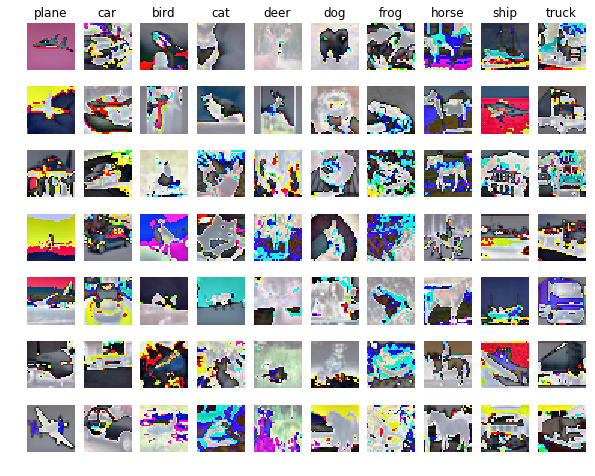

In [4]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8').transpose(1, 2, 0))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [5]:
import lasagne
from theano import tensor as T
from lasagne.nonlinearities import *

input_X = T.tensor4("X")
target_y = T.vector("target Y integer",dtype='int32')

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5110)


In [6]:
from wide_net import WideNet

In [7]:
from lasagne.updates import nesterov_momentum

In [1]:
# Возьмём WideResNet из статьи https://arxiv.org/abs/1605.07146

In [43]:
net = WideNet(input_X)

WideResNet depth of 16 width of 4


In [44]:
output_train = lasagne.layers.get_output(net)
output_test = lasagne.layers.get_output(net, deterministic=True)

In [45]:
loss = lasagne.objectives.categorical_crossentropy(output_train, target_y).mean()

In [46]:
all_layers = lasagne.layers.get_all_layers(net)
l2_penalty = lasagne.regularization.regularize_layer_params(all_layers, lasagne.regularization.l2) * 0.0001
loss = loss + l2_penalty

In [47]:
accuracy = lasagne.objectives.categorical_accuracy(output_train, target_y).mean()
ac_pr = lasagne.objectives.categorical_accuracy(output_test, target_y).mean()

In [48]:
LR_SCHEDULE = {
    0: 0.1,
    80: 0.01,
    120: 0.001,
}

In [49]:
l_r = theano.shared(np.array(LR_SCHEDULE[0], dtype=theano.config.floatX))
params = lasagne.layers.get_all_params(net, trainable=True)
updates = nesterov_momentum(loss, params, learning_rate=l_r, momentum=0.9)

In [50]:
train_fun = theano.function([input_X, target_y], [loss, accuracy], updates=updates, allow_input_downcast=True)
accuracy_fun = theano.function([input_X,target_y], accuracy, allow_input_downcast=True)
test_accuracy_fun = theano.function([input_X,target_y], ac_pr, allow_input_downcast=True)

### Вот и всё, пошли её учить

In [53]:
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

In [54]:
X_val, y_val = X_test, y_test
batch_size = 1024
PIXELS = 32
PAD_CROP = 4
PAD_PIXELS = PIXELS + (PAD_CROP * 2)

In [ ]:
def augment(batch):
    X, y = batch
    trans_1 = random.randint(0, (PAD_CROP*2))
    trans_2 = random.randint(0, (PAD_CROP*2))
    crop_x1 = trans_1
    crop_x2 = (PIXELS + trans_1)
    crop_y1 = trans_2
    crop_y2 = (PIXELS + trans_2)

    # flip left-right choice
    flip_lr = random.randint(0,1)

    # set empty copy to hold augmented images so that we don't overwrite
    X_aug = np.copy(X)

    # for each image in the batch do the augmentation
    for j in range(X.shape[0]):
        # for each image channel
        for k in range(X.shape[1]):
            # pad and crop images
            img_pad = np.pad(X_aug[j,k], pad_width=((PAD_CROP,PAD_CROP), (PAD_CROP,PAD_CROP)), mode='constant')
            X_aug[j,k] = img_pad[crop_x1:crop_x2, crop_y1:crop_y2]

            # flip left-right if chosen
            if flip_lr == 1:
                X_aug[j,k] = np.fliplr(X_aug[j,k])
    return X_aug, y

# Процесс обучения

In [ ]:
import time
file = open("acc.txt", "w")

num_epochs = 130 #количество проходов по данным

for epoch in range(120, num_epochs):
    # количество эпох такое, т.к. я просто доучивал на новом learning rate в конце
    if epoch in LR_SCHEDULE:
        l_r.set_value(LR_SCHEDULE[epoch])
    # In each epoch, we do a full pass over the training data:
    train_err = 0
    train_acc = 0
    train_batches = 0
    start_time = time.time()
    for batch in iterate_minibatches(X_train, y_train,batch_size):
        inputs, targets = augment(batch)
        train_err_batch, train_acc_batch = train_fun(inputs, targets)
        train_err += train_err_batch
        train_acc += train_acc_batch
        train_batches += 1
    # And a full pass over the validation data:
    val_acc = 0
    val_batches = 0
    for batch in iterate_minibatches(X_val, y_val, batch_size):
        inputs, targets = batch
        val_acc += test_accuracy_fun(inputs, targets)
        val_batches += 1

    # Then we print the results for this epoch:
    
    st = "Epoch {} of {} took {:.3f}s".format(epoch + 1, num_epochs, time.time() - start_time) +\
        "\n  training loss (in-iteration):\t\t{:.6f}".format(train_err / train_batches) + \
        "\n  train accuracy:\t\t{:.2f} %".format(train_acc / train_batches * 100) +\
        "\n  validation accuracy:\t\t{:.2f} %".format(val_acc / val_batches * 100)
    print(st)

Epoch 121 of 130 took 215.364s
  training loss (in-iteration):		0.333907
  train accuracy:		100.00 %
  validation accuracy:		92.59 %
Epoch 122 of 130 took 216.045s
  training loss (in-iteration):		0.334057
  train accuracy:		99.99 %
  validation accuracy:		92.64 %
Epoch 123 of 130 took 215.965s
  training loss (in-iteration):		0.333799
  train accuracy:		100.00 %
  validation accuracy:		92.64 %
Epoch 124 of 130 took 216.159s
  training loss (in-iteration):		0.333744
  train accuracy:		100.00 %
  validation accuracy:		92.63 %
Epoch 125 of 130 took 216.070s
  training loss (in-iteration):		0.333664
  train accuracy:		99.99 %
  validation accuracy:		92.65 %


In [64]:
test_acc = 0
test_batches = 0
for batch in iterate_minibatches(X_test, y_test, 500):
    inputs, targets = batch
    acc = test_accuracy_fun(inputs, targets)
    test_acc += acc
    test_batches += 1
print("Final results:")
print("  test accuracy:\t\t{:.2f} %".format(
    test_acc / test_batches * 100))

if test_acc / test_batches * 100 > 92.5:
    print("Achievement unlocked: колдун 80 уровня")
else:
    print("Нужно больше магии!")

Final results:
  test accuracy:		92.72 %
Achievement unlocked: колдун 80 уровня


## Заполните форму

https://goo.gl/forms/EeadABISlVmdJqgr2 

In [65]:
# save weights
from lasagne.layers import helper
import gzip
all_params = helper.get_all_param_values(net)
f = gzip.open('/weights/wide_2_4_resnet_92:72_nodropout.pklz', 'wb')
f.close()